In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading dataset 

In [ ]:
import numpy as np
import os
import cv2
import numpy as np
import imgaug.augmenters as iaa
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder


# Data Preprocessing

- Grayscale Conversion: Convert the images to grayscale format before feeding them into the model.
- Image Normalization: Normalize the pixel values of the images for better model performance
- Data agumentation : We generated 30 augmented images for each class. We chose the number 30 because, through experimentation, we found that it yielded a well-performing model.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

import os
import cv2
import numpy as np
import imgaug.augmenters as iaa
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Define the image dimensions and batch size
image_width, image_height = 200, 200
batch_size = 32

# Specify the paths to the directories
train_dir = '/content/drive/Shareddrives/BA865 - Team Project/Image_dataset/train'
validation_dir = '/content/drive/Shareddrives/BA865 - Team Project/Image_dataset/validation'

# Define the image preprocessing function
def preprocess_image(image_path):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resize the image
    img = cv2.resize(img, (image_width, image_height))

    # Apply adaptive thresholding
    img = cv2.adaptiveThreshold(img, 255, 1, 1, 11, 2)

    # Normalize the image
    img = img / 255.

    return img

# Define the data augmentation sequence
seq = iaa.Sequential([
    iaa.Affine(rotate=(-20, 20), scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}),
    iaa.Fliplr(0.5),
])


# Load and preprocess the training data
train_images = []
train_labels = []
num_augmentations_per_image = 30  
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        img = preprocess_image(image_path)
        
        # Perform data augmentation on the training data
        for _ in range(num_augmentations_per_image):
            img_aug = seq(image=img)  # Apply data augmentation
            train_images.append(img_aug)
            train_labels.append(class_name)

# Convert the lists to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# One-hot encode the labels
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
train_labels = to_categorical(train_labels)



# Do the same for the validation data, but without data augmentation
validation_images = []
validation_labels = []
for class_name in os.listdir(validation_dir):
    class_dir = os.path.join(validation_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        img = preprocess_image(image_path)
        validation_images.append(img)
        validation_labels.append(class_name)

# Convert the lists to numpy arrays
validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)

# One-hot encode the labels
validation_labels = le.transform(validation_labels)
validation_labels = to_categorical(validation_labels)

class_labels_train = os.listdir(train_dir)
class_labels_validation = os.listdir(validation_dir)

assert set(class_labels_train) == set(class_labels_validation), "Mismatch between training and validation classes"


# Dense model

In [ ]:

model = Sequential([
    Flatten(input_shape=(image_width, image_height, 1)),
    Dense(128, activation='relu'),
    Dense(34, activation='softmax')  
])


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_images, train_labels,
    epochs=10,
    validation_data=(validation_images, validation_labels)
)

# Evaluate the model
scores = model.evaluate(validation_images, validation_labels)
print(f"Validation accuracy: {scores[1]*100:.2f}%")


Epoch 1/10
79/79 [==============================] - 3s 9ms/step - loss: 3.9058 - accuracy: 0.0762 - val_loss: 3.8128 - val_accuracy: 0.0000e+00
Epoch 2/10
79/79 [==============================] - 0s 6ms/step - loss: 2.7206 - accuracy: 0.2258 - val_loss: 4.4257 - val_accuracy: 0.0294
Epoch 3/10
79/79 [==============================] - 0s 6ms/step - loss: 1.6832 - accuracy: 0.5194 - val_loss: 4.9154 - val_accuracy: 0.0882
Epoch 4/10
79/79 [==============================] - 1s 6ms/step - loss: 0.7913 - accuracy: 0.7722 - val_loss: 5.3017 - val_accuracy: 0.0882
Epoch 5/10
79/79 [==============================] - 0s 6ms/step - loss: 0.2908 - accuracy: 0.9532 - val_loss: 5.8160 - val_accuracy: 0.1176
Epoch 6/10
79/79 [==============================] - 0s 6ms/step - loss: 0.1115 - accuracy: 0.9909 - val_loss: 6.6378 - val_accuracy: 0.0588
Epoch 7/10
79/79 [==============================] - 0s 6ms/step - loss: 0.0463 - accuracy: 0.9992 - val_loss: 6.6521 - val_accuracy: 0.0882
Epoch 8/10
79/79

## Prediction on testset 

In [ ]:
# Define the path to the folder containing the test images
test_dir = '/content/drive/Shareddrives/BA865 - Team Project/Image_dataset/test'

# Define your class labels in the same order as during training
class_labels = class_labels_train   


In [ ]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def predict_single_image(model, image_path, target_size, class_labels):
    image = load_img(image_path, target_size=target_size, color_mode='grayscale')
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    prediction = model.predict(image_array)
    predicted_class_index = np.argmax(prediction, axis=-1)[0]
    predicted_class_label = class_labels[predicted_class_index]
    return predicted_class_label


def predict_multiple_images(model, folder_path, class_labels, target_size=(200, 200)):
    predicted_labels = {}
    for root, dirs, files in os.walk(folder_path):
        for image_filename in files:
            # Construct the full path to the image file
            image_path = os.path.join(root, image_filename)
            if os.path.isfile(image_path):  # Ensure that the item is a file
                predicted_class_label = predict_single_image(model, image_path, target_size, class_labels)
                predicted_labels[image_filename] = predicted_class_label
    return predicted_labels

# Use the trained model to predict the classes of the test images
predicted_labels = predict_multiple_images(model, test_dir, class_labels, target_size=(200, 200))
print('Predicted class labels for test images:')
for image_filename, predicted_class_label in predicted_labels.items():
    print(f'{image_filename}: {predicted_class_label}')


1/1 [==============================] - 0s 18ms/step
Predicted class labels for test images:
yes.0.png: moon
eat.0.png: train
car.0.png: train
train.0.png: train
love.1.png: sorry
today.0.png: train
read.0.png: girl
thanks.0.png: boy
airplane.0.png: train
computer.1.png: phone


# Conv2 model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Define the CNN model
model = Sequential([
    # Convolutional layer with 32 filters, each with size 3x3, and ReLU activation
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(200, 200, 1)),
    # Max pooling layer with pool size 2x2
    MaxPooling2D(pool_size=(2, 2)),
    # Dropout layer with 25% dropout rate
    Dropout(0.25),
    # Another convolutional layer with 64 filters, each with size 3x3, and ReLU activation
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    # Max pooling layer with pool size 2x2
    MaxPooling2D(pool_size=(2, 2)),
    # Dropout layer with 25% dropout rate
    Dropout(0.25),
    # Flatten layer to convert 3D feature maps to 1D feature vectors
    Flatten(),
    # Dense layer with 128 neurons and ReLU activation
    Dense(128, activation='relu'),
    # Dropout layer with 50% dropout rate
    Dropout(0.5),
    # Output layer with the number of neurons equal to the number of classes, using softmax activation
    Dense(34, activation='softmax') 
])


In [ ]:

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 99, 99, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 48, 48, 64)       

In [ ]:


from keras.callbacks import ModelCheckpoint

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'best_model.h5',  # Filepath to save the model
    monitor='val_accuracy',  # Monitor validation accuracy
    verbose=1,
    save_best_only=True,  # Save only the best model
    mode='max'  # Maximize validation accuracy
)

# Train the model with the ModelCheckpoint callback
history = model.fit(
    train_images, train_labels,
    epochs=10,
    validation_data=(validation_images, validation_labels),
    callbacks=[checkpoint]  # Include the checkpoint callback
)






Epoch 1/10
79/79 [==============================] - ETA: 0s - loss: 3.7069 - accuracy: 0.0496
Epoch 1: val_accuracy improved from -inf to 0.05882, saving model to best_model.h5
79/79 [==============================] - 10s 81ms/step - loss: 3.7069 - accuracy: 0.0496 - val_loss: 3.5240 - val_accuracy: 0.0588
Epoch 2/10
78/79 [============================>.] - ETA: 0s - loss: 3.3509 - accuracy: 0.0801
Epoch 2: val_accuracy did not improve from 0.05882
79/79 [==============================] - 5s 60ms/step - loss: 3.3486 - accuracy: 0.0810 - val_loss: 3.5322 - val_accuracy: 0.0294
Epoch 3/10
78/79 [============================>.] - ETA: 0s - loss: 2.6495 - accuracy: 0.2280
Epoch 3: val_accuracy improved from 0.05882 to 0.11765, saving model to best_model.h5
79/79 [==============================] - 5s 69ms/step - loss: 2.6468 - accuracy: 0.2286 - val_loss: 3.4460 - val_accuracy: 0.1176
Epoch 4/10
78/79 [============================>.] - ETA: 0s - loss: 1.8286 - accuracy: 0.4283
Epoch 4: val_

## Pre-train model to CNN 

Since the model performance decrease after using pre-trian model, we decided to not use it.

In [ ]:
# from keras.applications.vgg16 import VGG16
# from keras.models import Model
# from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten


# train_images = np.stack((train_images,) * 3, axis=-1)
# validation_images = np.stack((validation_images,) * 3, axis=-1)

# # Load the VGG16 pretrained model without the top dense layers
# conv_base = VGG16(
#     weights="imagenet",
#     include_top=False,  # Exclude the top dense layers
#     input_shape=(200, 200, 3)  # The input shape for the base model (grayscale images will need to be converted to RGB)
# )


# # Get the output of the base model
# x = conv_base.output

# # Add a global average pooling layer
# x = GlobalAveragePooling2D()(x)

# # Add a dropout layer (optional)
# x = Dropout(0.25)(x)

# # Add a dense layer with 128 neurons and ReLU activation
# x = Dense(128, activation='relu')(x)

# # Add a dropout layer with 50% dropout rate
# x = Dropout(0.5)(x)

# # Output layer with the number of neurons equal to the number of classes, using softmax activation
# num_classes = 34  # Number of classes to predict
# predictions = Dense(num_classes, activation='softmax')(x)

# # Create a new model combining the base model and custom layers
# model = Model(inputs=conv_base.input, outputs=predictions)

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Print a summary of the model architecture
# model.summary()

# # Train the model
# history = model.fit(
#     train_images, train_labels,
#     epochs=10,
#     validation_data=(validation_images, validation_labels)
# )

# # Evaluate the model on the validation data
# scores = model.evaluate(validation_images, validation_labels)
# print(f"Validation accuracy: {scores[1]*100:.2f}%")


## Prediction on testset

In [ ]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def predict_single_image(model, image_path, target_size, class_labels):
    image = load_img(image_path, target_size=target_size, color_mode='grayscale')
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    prediction = model.predict(image_array)
    predicted_class_index = np.argmax(prediction, axis=-1)[0]
    predicted_class_label = class_labels[predicted_class_index]
    return predicted_class_label


def predict_multiple_images(model, folder_path, class_labels, target_size=(200, 200)):
    predicted_labels = {}
    for root, dirs, files in os.walk(folder_path):
        for image_filename in files:
            # Construct the full path to the image file
            image_path = os.path.join(root, image_filename)
            if os.path.isfile(image_path):  # Ensure that the item is a file
                predicted_class_label = predict_single_image(model, image_path, target_size, class_labels)
                predicted_labels[image_filename] = predicted_class_label
    return predicted_labels



class_labels = class_labels_train  


In [ ]:
# Use the trained model to predict the classes of the test images
predicted_labels = predict_multiple_images(model, test_dir, class_labels, target_size=(200, 200))
print('Predicted class labels for test images:')
for image_filename, predicted_class_label in predicted_labels.items():
    print(f'{image_filename}: {predicted_class_label}')

1/1 [==============================] - 0s 21ms/step
Predicted class labels for test images:
yes.0.png: moon
eat.0.png: boy
car.0.png: me
train.0.png: train
love.1.png: iloveyou
today.0.png: me
read.0.png: train
thanks.0.png: boy
airplane.0.png: thanks
computer.1.png: computer


## Grid search 

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Define a function to create the CNN model
def create_model(optimizer='adam', learning_rate=0.001, dropout_rate=0.25):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(200, 200, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_rate),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_rate),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(34, activation='softmax') 
    ])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create a KerasClassifier wrapper for the CNN model
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define the hyperparameters and their possible values
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'learning_rate': [0.001, 0.01],
    'dropout_rate': [0.25, 0.5]
}

# Perform grid search with cross-validation
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2)
grid_result = grid.fit(train_images, train_labels)  # Use your training data here

# Print the best hyperparameters and the corresponding accuracy
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Fitting 3 folds for each of 8 candidates, totalling 24 fits


<ipython-input-13-41a121cfafdd>:22: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


[CV] END dropout_rate=0.25, learning_rate=0.001, optimizer=adam; total time=   7.7s
[CV] END dropout_rate=0.25, learning_rate=0.001, optimizer=adam; total time=   8.0s
[CV] END dropout_rate=0.25, learning_rate=0.001, optimizer=adam; total time=   8.1s
[CV] END dropout_rate=0.25, learning_rate=0.001, optimizer=rmsprop; total time=   7.5s
[CV] END dropout_rate=0.25, learning_rate=0.001, optimizer=rmsprop; total time=   5.8s
[CV] END dropout_rate=0.25, learning_rate=0.001, optimizer=rmsprop; total time=   7.9s
[CV] END dropout_rate=0.25, learning_rate=0.01, optimizer=adam; total time=   8.8s
[CV] END dropout_rate=0.25, learning_rate=0.01, optimizer=adam; total time=   8.0s
[CV] END dropout_rate=0.25, learning_rate=0.01, optimizer=adam; total time=   6.7s
[CV] END dropout_rate=0.25, learning_rate=0.01, optimizer=rmsprop; total time=   7.8s
[CV] END dropout_rate=0.25, learning_rate=0.01, optimizer=rmsprop; total time=   7.7s
[CV] END dropout_rate=0.25, learning_rate=0.01, optimizer=rmsprop;

### Implement best hyperparameters

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint

# Retrieve the best hyperparameters from the grid search result
best_learning_rate = grid_result.best_params_['learning_rate']
best_dropout_rate = grid_result.best_params_['dropout_rate']
best_optimizer = grid_result.best_params_['optimizer']

# Define the CNN model with the best hyperparameters
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(200, 200, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(best_dropout_rate),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(best_dropout_rate),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(34, activation='softmax')
])

# Create an instance of the optimizer with the best learning rate
optimizer = Adam(learning_rate=best_learning_rate) if best_optimizer == 'adam' else RMSprop(learning_rate=best_learning_rate)

# Compile the model with the best optimizer and learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define a ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h6',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Train the model with the updated hyperparameters and the ModelCheckpoint callback
history = model.fit(
    train_images, train_labels,
    epochs=10,
    validation_data=(validation_images, validation_labels),
    callbacks=[checkpoint_callback]  # Include the ModelCheckpoint callback in the list of callbacks
)

# Retrieve the validation accuracy history
val_accuracy_history = history.history['val_accuracy']

# Print the best validation accuracy achieved during training
best_val_accuracy = max(val_accuracy_history)
print(f"Best validation accuracy: {best_val_accuracy*100:.2f}%")


Epoch 1/10
78/79 [============================>.] - ETA: 0s - loss: 3.7140 - accuracy: 0.0445
Epoch 1: val_accuracy improved from -inf to 0.02941, saving model to best_model.h6


79/79 [==============================] - 8s 92ms/step - loss: 3.7116 - accuracy: 0.0452 - val_loss: 3.5119 - val_accuracy: 0.0294
Epoch 2/10
78/79 [============================>.] - ETA: 0s - loss: 3.3757 - accuracy: 0.0729
Epoch 2: val_accuracy improved from 0.02941 to 0.08824, saving model to best_model.h6


79/79 [==============================] - 7s 88ms/step - loss: 3.3721 - accuracy: 0.0742 - val_loss: 3.4486 - val_accuracy: 0.0882
Epoch 3/10
78/79 [============================>.] - ETA: 0s - loss: 2.9374 - accuracy: 0.1619
Epoch 3: val_accuracy improved from 0.08824 to 0.17647, saving model to best_model.h6


79/79 [==============================] - 7s 84ms/step - loss: 2.9376 - accuracy: 0.1615 - val_loss: 3.3614 - val_accuracy: 0.1765
Epoch 4/10
78/79 [============================>.] - ETA: 0s - loss: 2.2861 - accuracy: 0.2929
Epoch 4: val_accuracy improved from 0.17647 to 0.20588, saving model to best_model.h6


79/79 [==============================] - 6s 82ms/step - loss: 2.2864 - accuracy: 0.2937 - val_loss: 3.4767 - val_accuracy: 0.2059
Epoch 5/10
78/79 [============================>.] - ETA: 0s - loss: 1.8904 - accuracy: 0.3942
Epoch 5: val_accuracy did not improve from 0.20588
79/79 [==============================] - 5s 61ms/step - loss: 1.8894 - accuracy: 0.3944 - val_loss: 3.7177 - val_accuracy: 0.2059
Epoch 6/10
78/79 [============================>.] - ETA: 0s - loss: 1.5894 - accuracy: 0.4868
Epoch 6: val_accuracy did not improve from 0.20588
79/79 [==============================] - 5s 59ms/step - loss: 1.5905 - accuracy: 0.4861 - val_loss: 4.7487 - val_accuracy: 0.1471
Epoch 7/10
78/79 [============================>.] - ETA: 0s - loss: 1.3182 - accuracy: 0.5677
Epoch 7: val_accuracy did not improve from 0.20588
79/79 [==============================] - 5s 59ms/step - loss: 1.3203 - accuracy: 0.5683 - val_loss: 4.9869 - val_accuracy: 0.1471
Epoch 8/10
78/79 [===========================

In [ ]:
# Use the best model to predict the classes of the test images
predicted_labels = predict_multiple_images(model, test_dir, class_labels, target_size=(200, 200))
print('Predicted class labels for test images:')
for image_filename, predicted_class_label in predicted_labels.items():
    print(f'{image_filename}: {predicted_class_label}')

1/1 [==============================] - 0s 36ms/step
Predicted class labels for test images:
yes.0.png: beer
eat.0.png: ask
car.0.png: eat
train.0.png: eat
love.1.png: beer
today.0.png: cat
read.0.png: moon
thanks.0.png: boy
airplane.0.png: car
computer.1.png: cat


# Shape

SHAP explanations kept crashing because they used up all the memory, so we chose not to use them.

In [ ]:
# !pip install shap

In [ ]:
# import shap
# import numpy as np
# import os
# from tensorflow.keras.preprocessing.image import load_img, img_to_array

# # Convert the test images to an array for SHAP
# test_images = []
# for root, dirs, files in os.walk(test_dir):
#     for image_filename in files:
#         image_path = os.path.join(root, image_filename)
#         if os.path.isfile(image_path):
#             image = load_img(image_path, target_size=(200, 200), color_mode='grayscale')
#             image_array = img_to_array(image)
#             image_array = np.expand_dims(image_array, axis=-1)  # Ensure the image has a single channel
#             test_images.append(image_array)
# test_images = np.array(test_images)

# # Create a background dataset by selecting a subset of training images
# num_background_samples = 20  # Reduce the number of background samples
# background = train_images[np.random.choice(train_images.shape[0], num_background_samples, replace=False)]

# # Initialize the GradientExplainer
# explainer = shap.GradientExplainer(model, background)


# batch_size = 5  # Process images in batches of 5
# num_batches = (len(test_images) + batch_size - 1) // batch_size
# for i in range(num_batches):
#     batch_test_images = test_images[i*batch_size:(i+1)*batch_size]
#     shap_values = explainer.shap_values(batch_test_images)
#     # Plot the SHAP explanations for each batch
#     shap.image_plot(shap_values, batch_test_images.astype(np.uint8))

# # Display the predicted class labels for test images
# print('Predicted class labels for test images:')
# for image_filename, predicted_class_label in predicted_labels.items():
#     print(f'{image_filename}: {predicted_class_label}')


# Lime

In [ ]:
import matplotlib.pyplot as plt

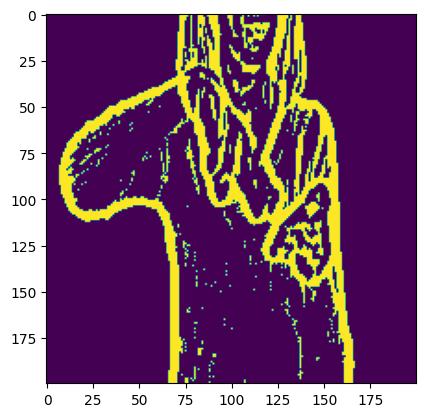

In [ ]:
plt.imshow(validation_images[6])

In [ ]:
try:
  import lime
  from lime import lime_image
except ImportError as error:
  !pip install lime
  import lime 
  from lime import lime_image

import random
import numpy as np

# Reshape the train and validation images to (num_samples, image_width, image_height, num_channels)
train_images = np.expand_dims(train_images, axis=-1)
validation_images = np.expand_dims(validation_images, axis=-1)

# Convert the grayscale images to RGB
def to_rgb(images):
    images_rgb = np.zeros((images.shape[0], images.shape[1], images.shape[2], 3))
    for i in range(3):
        images_rgb[..., i] = images[..., 0]
    return images_rgb

x_train_rgb = to_rgb(train_images)
x_test_rgb = to_rgb(validation_images)

# Define a new predict function that accepts RGB images
def new_predict(images):
    images = images[..., 0].reshape(images.shape[0], images.shape[1], images.shape[2], 1)
    predictions = model.predict(images)
    return predictions


In [ ]:
try:
  from skimage.segmentation import mark_boundaries
except ImportError as error:
  !pip install skimage 
  from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Instantiate our LIME explainer.
explainer = lime_image.LimeImageExplainer()

# Now use it to 'explain' the first test image.
explanation = explainer.explain_instance(x_test_rgb[6], new_predict, num_samples=1000, top_labels=10, hide_color=1)

print(f'The rank ordering of most probable labels for this image is as follows: {explanation.top_labels}.')


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step
The rank ordering of most probable labels for this image is as follows: [26, 19, 8, 7, 28, 5, 13, 14, 0, 6].


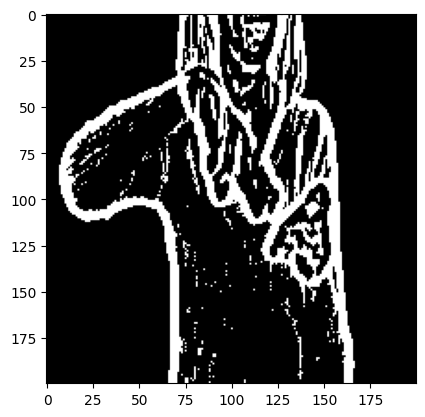

In [ ]:
plt.imshow(x_test_rgb[6])
plt.show()

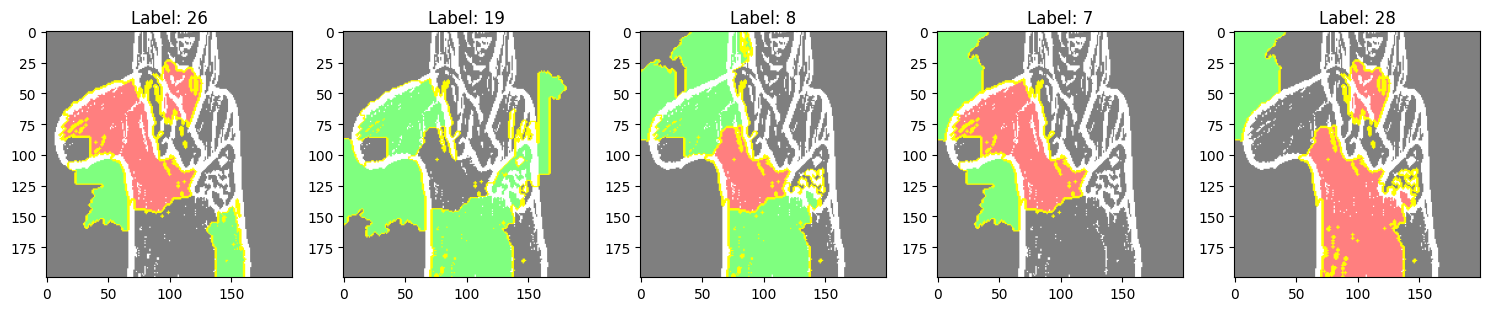

In [ ]:

# Number of top labels to display
num_top_labels = 5

# Create a figure with multiple subplots
figure, axes = plt.subplots(nrows=1, ncols=num_top_labels, figsize=(15, 3))

# Loop through the top labels and display the LIME explanations
for i in range(num_top_labels):
    # Get the 'temperature', i.e., the marginal effect of pixels, relative to each outcome label
    label = explanation.top_labels[i]
    # Get the image and mask for the associated label 
    temp, mask = explanation.get_image_and_mask(label, positive_only=False, hide_rest=False)
    # Add a plot for the associated label 
    axes[i].imshow(mark_boundaries(temp / 2 + 0.5, mask))
    axes[i].set_title(f"Label: {label}")

# Display the figure
plt.tight_layout()
plt.show()
